## **IT Service Ticket Classification**

In [1]:
# Import dependencies
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os, pathlib, shutil, random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import imdb
from tensorflow.keras import Sequential, Input, Model, layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, AveragePooling2D
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Dense, Flatten, Softmax, Dropout, Embedding, SimpleRNN, LSTM, GRU, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
#from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, Rescaling, RandomWidth, RandomHeight, Lambda
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.metrics import geometric_mean_score
from sklearn.utils.class_weight import compute_class_weight

In [2]:
tf.__version__

'2.15.0'

In [3]:
pd.__version__

'2.2.1'

In [4]:
np.__version__

'1.26.4'

In [5]:
output_path = r"C:\Users\10741836\OneDrive - LTIMindtree\001 MCA\005_IT_Ticket_classfication\001_data\archive\all_tickets_processed_improved_v3.csv"

data = pd.read_csv(output_path)

df = data.copy()


# test
df_top = data.copy()

print(df.head())
print(df.shape)

                                            Document    Topic_group
0  connection with icon icon dear please setup ic...       Hardware
1  work experience user work experience user hi w...         Access
2  requesting for meeting requesting meeting hi p...       Hardware
3  reset passwords for external accounts re expir...         Access
4  mail verification warning hi has got attached ...  Miscellaneous
(47837, 2)


# Data Exploration

In [6]:
df['Topic_group'].unique()

array(['Hardware', 'Access', 'Miscellaneous', 'HR Support', 'Purchase',
       'Administrative rights', 'Storage', 'Internal Project'],
      dtype=object)

In [7]:
df['Topic_group'].value_counts()

Topic_group
Hardware                 13617
HR Support               10915
Access                    7125
Miscellaneous             7060
Storage                   2777
Purchase                  2464
Internal Project          2119
Administrative rights     1760
Name: count, dtype: int64

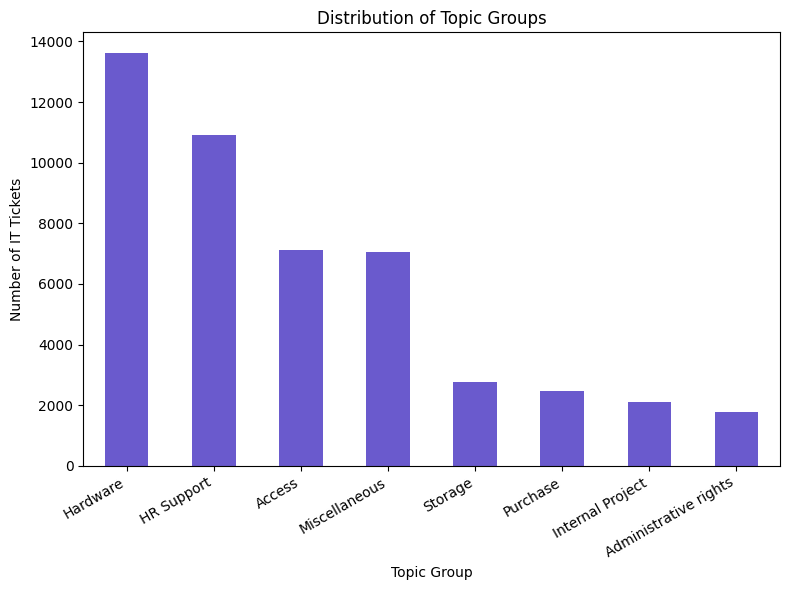

In [8]:
# Distribution of Topic Groups
topic_count = df['Topic_group'].value_counts()

plt.figure(figsize=(8, 6))
topic_count.plot(kind='bar', color='slateblue')
plt.title('Distribution of Topic Groups')
plt.xlabel('Topic Group')
plt.ylabel('Number of IT Tickets')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

In [9]:
# Documental Length Analysis
print('Average number of characters:', df['Document'].apply(len).mean())
print('Average number of words:', df['Document'].apply(lambda x: len(x.split())).mean())

Average number of characters: 291.8812634571566
Average number of words: 43.597340970378575


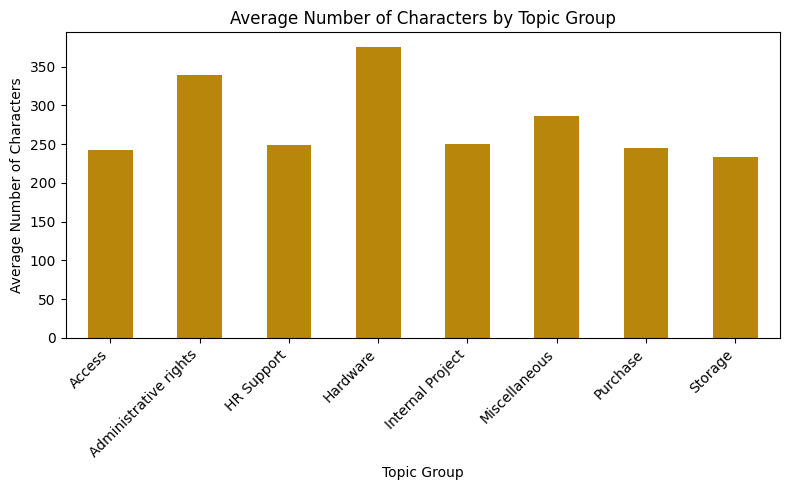

In [10]:
# Average number of characters for each topic group
avg_chars_by_group = df.groupby('Topic_group')['Document'].apply(lambda x: x.str.len().mean())

plt.figure(figsize=(8, 5))
avg_chars_by_group.plot(kind='bar', color='darkgoldenrod')
plt.title('Average Number of Characters by Topic Group')
plt.xlabel('Topic Group')
plt.ylabel('Average Number of Characters')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

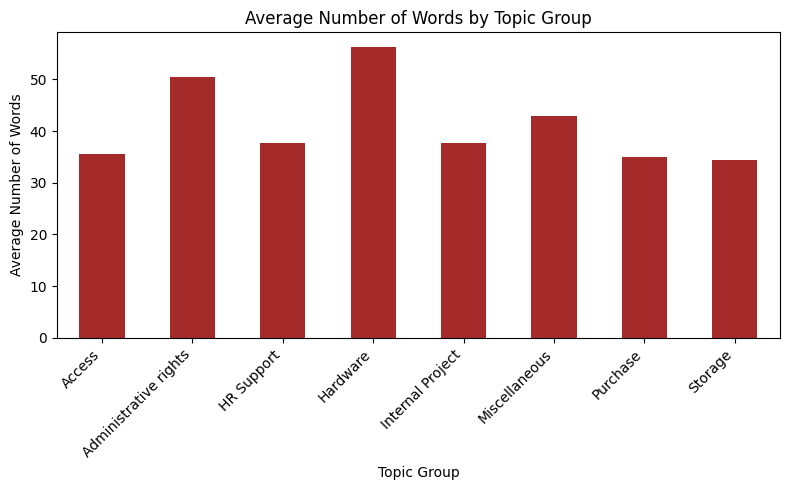

In [11]:
# Average number of words for each topic group
avg_words_by_group = df.groupby('Topic_group')['Document'].apply(lambda x: x.apply(lambda y: len(y.split())).mean())

plt.figure(figsize=(8, 5))
avg_words_by_group.plot(kind='bar', color='brown')
plt.title('Average Number of Words by Topic Group')
plt.xlabel('Topic Group')
plt.ylabel('Average Number of Words')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Data Preparation - Part 1

In [12]:
# check missing values
df.isnull().any()

Document       False
Topic_group    False
dtype: bool

In [13]:
# check duplicate
df[df.duplicated()]

,Document,Topic_group


In [14]:
# check data is balanced or not -> imbalanced dataset
print("Proportion of each category:")
print(df['Topic_group'].value_counts(normalize=True))

Proportion of each category:
Topic_group
Hardware                 0.284654
HR Support               0.228171
Access                   0.148943
Miscellaneous            0.147585
Storage                  0.058051
Purchase                 0.051508
Internal Project         0.044296
Administrative rights    0.036792
Name: proportion, dtype: float64


In [15]:
# shuffle the DataFrame rows
df = df.sample(frac=1, random_state=28)

df.head()

# Find the unique values in the "Topic_group" column
unique_categories = df['Topic_group'].unique()
print("Unique categories:", unique_categories, "\n")

# Plot a bar plot showing the distribution of categories
category_counts = df['Topic_group'].value_counts()
print(category_counts, "\n")


Unique categories: ['Hardware' 'Miscellaneous' 'Access' 'Storage' 'Internal Project'
 'HR Support' 'Administrative rights' 'Purchase'] 

Topic_group
Hardware                 13617
HR Support               10915
Access                    7125
Miscellaneous             7060
Storage                   2777
Purchase                  2464
Internal Project          2119
Administrative rights     1760
Name: count, dtype: int64 



In [16]:
# Get the indices for each category
hardware_indices = df[df['Topic_group'] == 'Hardware'].index
hr_support_indices = df[df['Topic_group'] == 'HR Support'].index
access_indices = df[df['Topic_group'] == 'Access'].index
miscellaneous_indices = df[df['Topic_group'] == 'Miscellaneous'].index

# Create a list of indices to drop
indices_to_drop = random.sample(list(hardware_indices), len(hardware_indices) - 5000) + \
                  random.sample(list(hr_support_indices), len(hr_support_indices) - 5000) + \
                  random.sample(list(access_indices), len(access_indices) - 5000) + \
                  random.sample(list(miscellaneous_indices), len(miscellaneous_indices) - 5000)

# Drop the rows
df_downsample = df.drop(indices_to_drop)

# Check the number of rows for each category
print(df_downsample.shape)
print("Hardware count:", df_downsample[df_downsample['Topic_group'] == 'Hardware'].shape[0])
print("HR Support count:", df_downsample[df_downsample['Topic_group'] == 'HR Support'].shape[0])
print("Access count:", df_downsample[df_downsample['Topic_group'] == 'Access'].shape[0])
print("Miscellaneous count:", df_downsample[df_downsample['Topic_group'] == 'Miscellaneous'].shape[0])



# Find the unique values in the "Topic_group" column
unique_categories = df_downsample['Topic_group'].unique()
print("Unique categories:", unique_categories, "\n")

# Plot a bar plot showing the distribution of categories
category_counts = df_downsample['Topic_group'].value_counts()
print(category_counts, "\n")

(29120, 2)
Hardware count: 5000
HR Support count: 5000
Access count: 5000
Miscellaneous count: 5000
Unique categories: ['Miscellaneous' 'Access' 'Hardware' 'Storage' 'Internal Project'
 'HR Support' 'Administrative rights' 'Purchase'] 

Topic_group
Miscellaneous            5000
Access                   5000
Hardware                 5000
HR Support               5000
Storage                  2777
Purchase                 2464
Internal Project         2119
Administrative rights    1760
Name: count, dtype: int64 



In [17]:
df = df_downsample.copy()

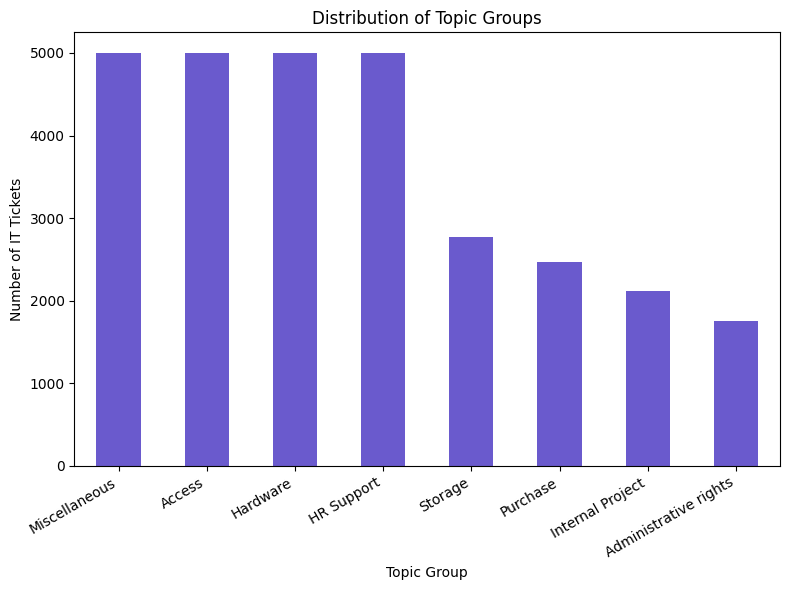

In [20]:
# Distribution of Topic Groups
topic_count = df['Topic_group'].value_counts()

plt.figure(figsize=(8, 6))
topic_count.plot(kind='bar', color='slateblue')
plt.title('Distribution of Topic Groups')
plt.xlabel('Topic Group')
plt.ylabel('Number of IT Tickets')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.savefig(r"C:\Users\10741836\OneDrive - LTIMindtree\001 MCA\005_IT_Ticket_classfication\004_output\Distrubution_of_topic_group.png")
plt.show()


In [21]:
# Documental Length Analysis
print('Average number of characters:', df['Document'].apply(len).mean())
print('Average number of words:', df['Document'].apply(lambda x: len(x.split())).mean())

Average number of characters: 281.3364010989011
Average number of words: 41.887122252747254


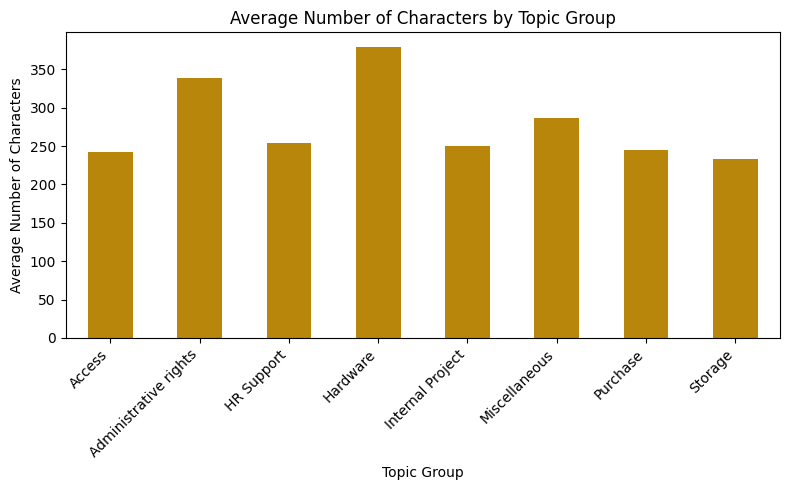

In [24]:
# Average number of characters for each topic group
avg_chars_by_group = df.groupby('Topic_group')['Document'].apply(lambda x: x.str.len().mean())

plt.figure(figsize=(8, 5))
avg_chars_by_group.plot(kind='bar', color='darkgoldenrod')
plt.title('Average Number of Characters by Topic Group')
plt.xlabel('Topic Group')
plt.ylabel('Average Number of Characters')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(r"C:\Users\10741836\OneDrive - LTIMindtree\001 MCA\005_IT_Ticket_classfication\004_output\Average_of_character_in_topic_group.png")
plt.show()

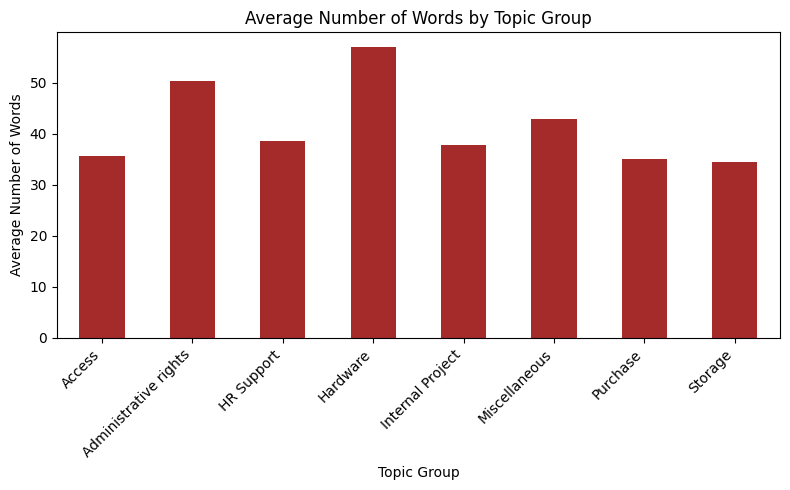

In [25]:
# Average number of words for each topic group
avg_words_by_group = df.groupby('Topic_group')['Document'].apply(lambda x: x.apply(lambda y: len(y.split())).mean())

plt.figure(figsize=(8, 5))
avg_words_by_group.plot(kind='bar', color='brown')
plt.title('Average Number of Words by Topic Group')
plt.xlabel('Topic Group')
plt.ylabel('Average Number of Words')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(r"C:\Users\10741836\OneDrive - LTIMindtree\001 MCA\005_IT_Ticket_classfication\004_output\Average_of_words_in_topic_group.png")
plt.show()

In [26]:
# label encode
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['Topic_group'] = label_encoder.fit_transform(df['Topic_group']).astype('int32')
label_encoder.classes_

array(['Access', 'Administrative rights', 'HR Support', 'Hardware',
       'Internal Project', 'Miscellaneous', 'Purchase', 'Storage'],
      dtype=object)

In [94]:
import joblib
joblib.dump(label_encoder, r'C:\Users\10741836\OneDrive - LTIMindtree\001 MCA\005_IT_Ticket_classfication\005_model\label_encoder.joblib')


['C:\\Users\\10741836\\OneDrive - LTIMindtree\\001 MCA\\005_IT_Ticket_classfication\\005_model\\label_encoder.joblib']

In [27]:
df['Topic_group']

2292     5
43308    0
37222    3
12436    5
39553    7
        ..
39384    3
27122    2
7944     2
16471    7
4089     7
Name: Topic_group, Length: 29120, dtype: int32

In [31]:
df.rename(columns={'Document': 'x', 'Topic_group': 'y'}, inplace=True)
# Split data into train, validation and test sets
from sklearn.model_selection import train_test_split
train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['y'])
#train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42, stratify=train_val_df['y'])

train_df = train_val_df
val_df = test_df.copy()

train_df.shape, val_df.shape, test_df.shape


((23296, 2), (5824, 2), (5824, 2))

In [32]:
train_df['y'].value_counts().sort_index()

y
0    4000
1    1408
2    4000
3    4000
4    1695
5    4000
6    1971
7    2222
Name: count, dtype: int64

In [33]:
train_ds = tf.data.Dataset.from_tensor_slices((train_df['x'].values, train_df['y'].values))
val_ds = tf.data.Dataset.from_tensor_slices((val_df['x'].values, val_df['y'].values))
test_ds = tf.data.Dataset.from_tensor_slices((test_df['x'].values, test_df['y'].values))

batch_size = 32
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

print(type(train_ds), type(val_ds), type(test_ds))

<class 'tensorflow.python.data.ops.batch_op._BatchDataset'> <class 'tensorflow.python.data.ops.batch_op._BatchDataset'> <class 'tensorflow.python.data.ops.batch_op._BatchDataset'>


In [34]:
for inputs, targets in train_ds:
  print("inputs.shape:", inputs.shape)
  print("inputs.dtype:", inputs.dtype)
  print("targets.shape:", targets.shape)
  print("targets.dtype:", targets.dtype)
  print("inputs[0]:", inputs[0])
  print("targets[0]:", targets[0])
  break

inputs.shape: (32,)
inputs.dtype: <dtype: 'string'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>
inputs[0]: tf.Tensor(b'new project oracle fusion thursday july re hi video mentioned created by administrators main query although mentioned rights create code thus please create attached please thank officer', shape=(), dtype=string)
targets[0]: tf.Tensor(4, shape=(), dtype=int32)


In [35]:
text_only_train_ds = train_ds.map(lambda x, y: x)
for batch in text_only_train_ds.take(1):
    print(batch)

tf.Tensor(
[b'new project oracle fusion thursday july re hi video mentioned created by administrators main query although mentioned rights create code thus please create attached please thank officer'
 b'urgent project code to be set up spare urgent code spare hello please assign kind regards wednesday urgent code spare importance high hi please help urgent please code spare manage chart accounts manage values infrastructure thanks senior accountant ext'
 b'project manager for management codes bod and re codes hello everyone please note pm colombia changed possible immediately please change thanks head public holiday november re codes hello pm re waiting further indications kind regards thursday november pm re codes hi please pm she head colombia prefer pm please let other two codes hence believe close down agree opening code geography rather across geographies bit more tricky dedicated thinking pm thank thursday november re hello please find attached kind regards wednesday november pm

แล้วเพิ่ม embedding layer ไปใน get_model เลยจร้า

# Data Preparation - Part 2.2 Text Vectorization (Pretrained Word Embedding version)

In [ ]:
# download the GloVe word embeddings precomputed on the 2014 English Wikipedia dataset.
# It’s an 822 MB zip file containing 100-dimensional embedding vectors for 400,000 words (or non-word tokens).
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

In [36]:
# Parsing the GloVe word-embeddings file to build an index that maps words (as strings)
# to their vector representation.
path_to_glove_file = r"C:\Users\10741836\OneDrive - LTIMindtree\001 MCA\005_IT_Ticket_classfication\001_data\glove.6B\glove.6B.100d.txt"
#path_to_glove_file = r"C:\Users\10741836\OneDrive - LTIMindtree\001 MCA\005_IT_Ticket_classfication\001_data\glove.6B\glove.6B.50d.txt"


embeddings_index = {}
with open(path_to_glove_file,encoding="utf8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


In [37]:
embeddings_index.get('the')

array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
       -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
        0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
       -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
        0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
       -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
        0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
        0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
       -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
       -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
       -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
       -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
       -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
       -1.2526  ,  0.071624,  0.70565 ,  0.49744 , 

In [38]:
max_length = 500
max_tokens = 20000

# Preparing integer sequence datasets - standardization and tokenizartion
text_vectorization = TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

In [39]:
# Preparing the GloVe word-embeddings matrix that you can load into an Embedding layer.
# It must be a matrix of shape (max_words, embedding_dim), where each entry i contains
# the embedding_dim-dimensional vector for the word of index i in the reference word
# index (built during tokenization).
embedding_dim = 100
max_tokens = 20000

# Retrieve the vocabulary indexed by our previous TextVectorization layer.
vocabulary = text_vectorization.get_vocabulary()

# Use it to create a mapping from words to their index in the vocabulary.
word_index = dict(zip(vocabulary, range(len(vocabulary))))

# Prepare a matrix that we’ll fill with the GloVe vectors.
embedding_matrix = np.zeros((max_tokens, embedding_dim))

for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    # Fill entry i in the matrix with the word vector for index i.
    # Words not found in the embedding index will be all zeros.
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [40]:
embedding_layer = Embedding(
    max_tokens,
    embedding_dim,
    # use a Constant initializer to load the pretrained embeddings in an Embedding layer.
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    # freeze the layer via trainable=False: so as to not to disrupt the pretrained representations during training
    trainable=False,
    mask_zero=True,
)

In [41]:
y_values = np.concatenate([y.numpy() for y in int_train_ds.map(lambda x, y: y)])
unique_classes, class_counts = np.unique(y_values, return_counts=True)
for label, count in zip(unique_classes, class_counts):
    print(f"Ticket {label}: {count} samples")

Ticket 0: 4000 samples
Ticket 1: 1408 samples
Ticket 2: 4000 samples
Ticket 3: 4000 samples
Ticket 4: 1695 samples
Ticket 5: 4000 samples
Ticket 6: 1971 samples
Ticket 7: 2222 samples


In [42]:
np.concatenate([x.numpy() for x in int_train_ds.map(lambda x, y: x)])

array([[  37,  116,   89, ...,    0,    0,    0],
       [ 243,  116,   33, ...,    0,    0,    0],
       [ 116,   74,    7, ...,    0,    0,    0],
       ...,
       [  40,   83,    7, ...,    0,    0,    0],
       [2056,   19,    3, ...,    0,    0,    0],
       [ 856, 1393,   19, ...,    0,    0,    0]], dtype=int64)

In [43]:
int_train_ds

<_ParallelMapDataset element_spec=(TensorSpec(shape=(None, 500), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

# Modeling - LSTM

Create an LSTM and fit it with the int_train_ds data, using int_val_ds as the performance metric during training. The model consists of 3 layers as follows :
* Embedding layer (input layer)
* LSTM layer (hidden layer) with 64 nodes
* Dense layer (output layer) with 8 nodes (number of classes)

In [76]:
# Define your LSTM model
LSTM_model = Sequential([
    embedding_layer, # From part 2
    Dropout(0.20),
    LSTM(units = 64, input_shape = (None, 500)),
    Dropout(0.20),
    #LSTM(units = 64,activation='relu'),
    #Dropout(0.20),
    Dense(units = 8, activation = 'softmax')
])

early_stop = EarlyStopping(monitor = 'val_loss', patience = 10)

from keras.callbacks import ModelCheckpoint
file_path = r"C:\Users\10741836\OneDrive - LTIMindtree\001 MCA\005_IT_Ticket_classfication\005_model\epoch_50_v1\checkpoint.model{epoch:02d}.h5"
checkpoint = ModelCheckpoint(file_path, save_freq = 'epoch', 
                             save_weights_only = False)

# Compile the model
LSTM_model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',  # Use sparse categorical cross-entropy
              metrics = ['accuracy'])

# Print the model summary
LSTM_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         2000000   
                                                                 
 dropout_19 (Dropout)        (None, None, 100)         0         
                                                                 
 lstm_11 (LSTM)              (None, 64)                42240     
                                                                 
 dropout_20 (Dropout)        (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 8)                 520       
                                                                 
Total params: 2042760 (7.79 MB)
Trainable params: 42760 (167.03 KB)
Non-trainable params: 2000000 (7.63 MB)
_________________________________________________________________


In [77]:
# Fit the model using the training set
LSTM_history = LSTM_model.fit(int_train_ds, epochs = 50,  # Adjust epochs as needed
          validation_data = int_val_ds,
         callbacks = [early_stop,checkpoint])

Epoch 1/50
728/728 [==============================] - 239s 320ms/step - loss: 1.3019 - accuracy: 0.5387 - val_loss: 0.8774 - val_accuracy: 0.6985
Epoch 2/50
728/728 [==============================] - 233s 320ms/step - loss: 0.8355 - accuracy: 0.7208 - val_loss: 0.7014 - val_accuracy: 0.7639
Epoch 3/50
728/728 [==============================] - 234s 321ms/step - loss: 0.6837 - accuracy: 0.7706 - val_loss: 0.6156 - val_accuracy: 0.7902
Epoch 4/50
728/728 [==============================] - 283s 389ms/step - loss: 0.6129 - accuracy: 0.7961 - val_loss: 0.5670 - val_accuracy: 0.8101
Epoch 5/50
728/728 [==============================] - 260s 357ms/step - loss: 0.5623 - accuracy: 0.8116 - val_loss: 0.5398 - val_accuracy: 0.8166
Epoch 6/50
728/728 [==============================] - 257s 352ms/step - loss: 0.5255 - accuracy: 0.8233 - val_loss: 0.5287 - val_accuracy: 0.8194
Epoch 7/50
728/728 [==============================] - 316s 434ms/step - loss: 0.4924 - accuracy: 0.8312 - val_loss: 0.5114 -

In [78]:
# save the model
from tensorflow.keras.models import Sequential, save_model, load_model
save_model(LSTM_model, r"C:\Users\10741836\OneDrive - LTIMindtree\001 MCA\005_IT_Ticket_classfication\005_model\lstm_univariate_epoch_50_17_v1.h5",save_format='h5')

C:\Users\10741836\AppData\Local\Temp\ipykernel_15716\693020241.py:3: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(LSTM_model, r"C:\Users\10741836\OneDrive - LTIMindtree\001 MCA\005_IT_Ticket_classfication\005_model\lstm_univariate_epoch_50_17_v1.h5",save_format='h5')


To check for overfitting using loss and accuracy graphs, let's outline the methods in a mutually understandable manner.

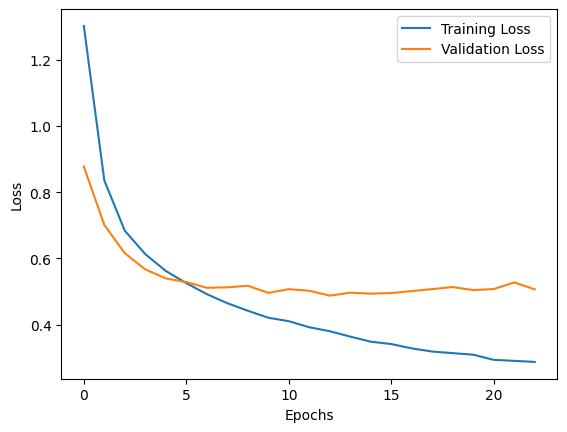

In [79]:
# Plot training and validation loss
plt.plot(LSTM_history.history['loss'], label='Training Loss')
plt.plot(LSTM_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

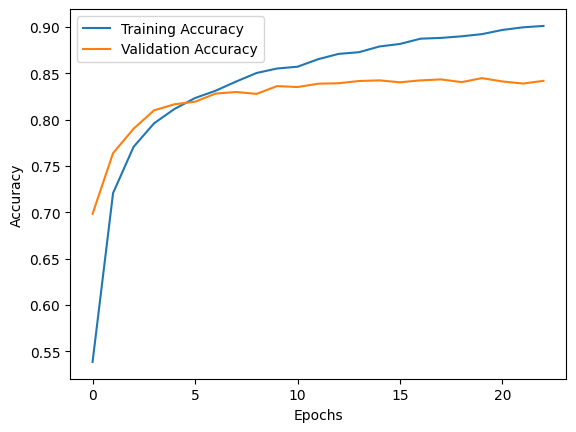

In [80]:
# Plot training and validation accuracy
plt.plot(LSTM_history.history['accuracy'], label='Training Accuracy')
plt.plot(LSTM_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Model Evaluation with Accuracy

In [81]:
# Evaluate the model using the test set
loss, accuracy = LSTM_model.evaluate(int_test_ds)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

182/182 [==============================] - 19s 105ms/step - loss: 0.5069 - accuracy: 0.8419
Test Loss: 0.5069392919540405
Test Accuracy: 0.8418612480163574


Model Evaluation with F1 score

In [82]:
# Predict on test set
predictions = LSTM_model.predict(int_test_ds)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate F1 score
f1 = f1_score(test_df['y'], predicted_labels, average='weighted')
print("F1 Score :", f1)

182/182 [==============================] - 24s 118ms/step
F1 Score : 0.8420565266526816


In [83]:
from sklearn.metrics import classification_report
print(classification_report(test_df['y'], predicted_labels))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88      1000
           1       0.79      0.77      0.78       352
           2       0.81      0.84      0.83      1000
           3       0.76      0.76      0.76      1000
           4       0.88      0.87      0.88       424
           5       0.83      0.83      0.83      1000
           6       0.93      0.91      0.92       493
           7       0.91      0.92      0.92       555

    accuracy                           0.84      5824
   macro avg       0.85      0.85      0.85      5824
weighted avg       0.84      0.84      0.84      5824



In [61]:
predicted_labels.shape

(5824,)

In [95]:
import joblib
label_enc = joblib.load(r'C:\Users\10741836\OneDrive - LTIMindtree\001 MCA\005_IT_Ticket_classfication\005_model\label_encoder.joblib')



In [96]:
result_csv = pd.DataFrame(test_df)
result_csv['predicted_categories'] = predicted_labels

result_csv.columns = ['description','orignal_categrories','predicted_categories']
result_csv['orignal_categrories' ] = label_enc.inverse_transform(result_csv['orignal_categrories' ] )
result_csv['predicted_categories' ] = label_enc.inverse_transform(result_csv['predicted_categories' ] )

result_csv

,description,orignal_categrories,predicted_categories
9421,request access to hello please provide members...,HR Support,HR Support
45340,expense report errors oracle sent tuesday dece...,HR Support,HR Support
12651,charger lid wednesday july pm charger lid than...,Hardware,Hardware
26376,new purchase po november purchase po dear purc...,Purchase,Purchase
22761,upgrade upgrade please upgrade storage per kno...,Administrative rights,Administrative rights
...,...,...,...
20424,new purchase po wednesday february pm re purch...,Purchase,Purchase
4369,daily data plan cost thought had deal cost per...,Storage,Hardware
30305,package for thursday pm package si la si la la...,Hardware,Hardware
13761,annual leave requests approval pm re annual le...,HR Support,HR Support


In [97]:
result_csv.to_csv(r"C:\Users\10741836\OneDrive - LTIMindtree\001 MCA\005_IT_Ticket_classfication\004_output\result.csv")

Create class weights for model training due to imbalanced data.